### Challenge Data Scientist - Neuralworks
#### Problema a resolver
Predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).

#### Dependencias
Este notebook fue desarrollado en python 3.9, usando todas las librerías a continuación:

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import datetime
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import airportsdata
from geopy.distance import geodesic as GD
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, confusion_matrix, plot_confusion_matrix

Los gráficos en `plotly` requieren de una extensión para ser visualizados correctamente desde VSCode.

#### Pregunta 1) Distribución de los datos
Importamos los datos y hacemos los primeros chequeos de la distribución, completitud y tipo de los datos.

In [40]:
df = pd.read_csv('dataset_SCL.csv', dtype={'Fecha-I':'str', 'Vlo-I': 'str', 'Ori-I': 'str', 'Des-I':'str', 'Emp-I': 'str',
'Fecha-O': 'str', 'Vlo-O': 'str', 'Ori-O': 'str','Des-O': 'str', 'Emp-O': 'str', 
'DIA': 'int', 'MES': 'int','AÑO': 'int', 'DIANOM': 'str', 
'TIPOVUELO': 'str', 'OPERA': 'str', 'SIGLAORI': 'str', 'SIGLADES': 'str'},parse_dates=['Fecha-I','Fecha-O'])

Revisamos la completitud del dataset con `msno`:

<AxesSubplot:>

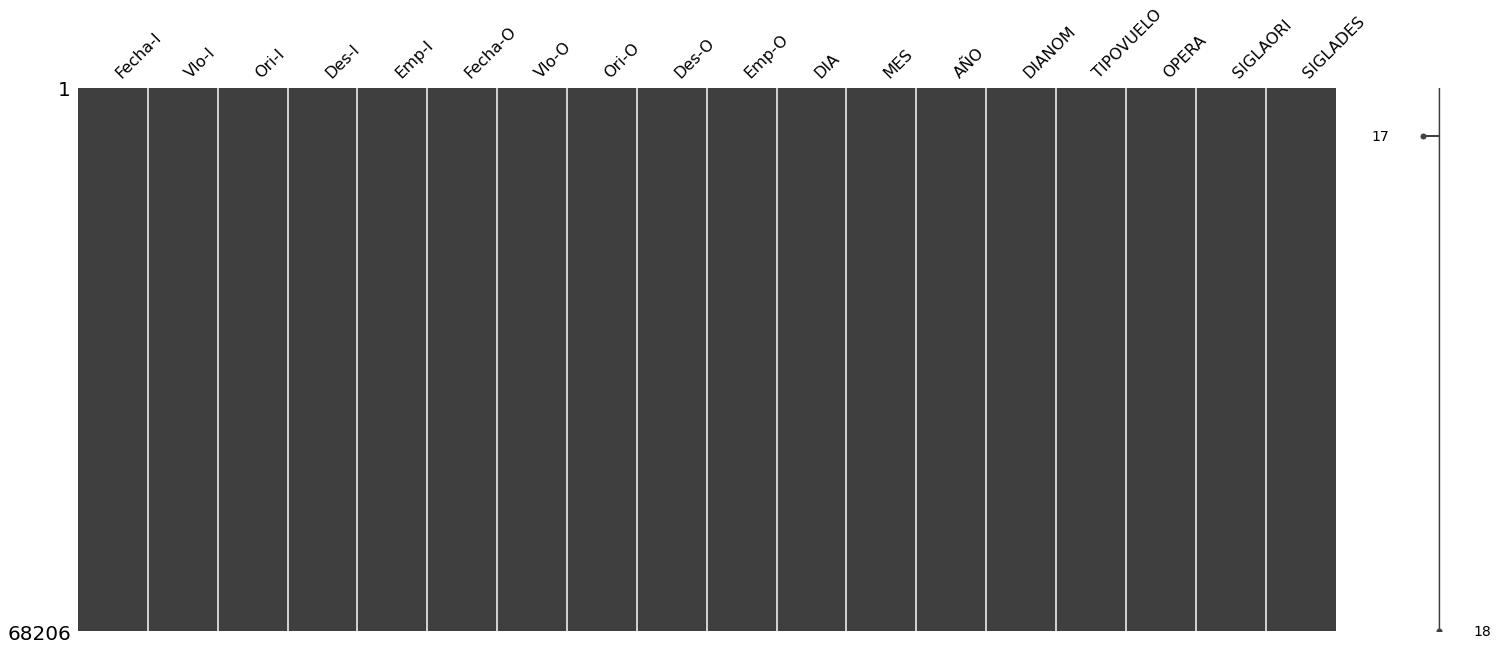

In [43]:
msno.matrix(df)

Notamos que hay un registro con valor nulo, por lo que exploramos en detalle:

In [44]:
df[df.isna().any(axis=1)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Revisamos si hay otros vuelos con las mismas características con el que podríamos inferir qué es ese valor faltane para imputarlo.

In [45]:
df.query('OPERA == "Latin American Wings" & SIGLADES == "Lima" & `Emp-O` == "56R" & `Vlo-I` == "200"', engine = 'python')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6067,2017-01-18 11:00:00,200,SCEL,SPJC,LAW,2017-01-18 11:06:00,200,SCEL,SPJC,56R,18,1,2017,Miercoles,I,Latin American Wings,Santiago,Lima
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Llegando a esto, podríamos tomar dos caminos: 
1) Inputar el valor de Vlo-O con "200", asumiendo sin mayor contexto que sería lo correcto
2) Descartar el dato dado que es ínfimo respecto al resto del dataset
3) Consultar a la contraparte correspondiente que emitió el dato.

Dada la agilidad y naturaleza del ejercicio, lo más práctico sería 2).

In [46]:
df.drop(6068, inplace=True)

Con lo anterior listo, podemos ir directo a ver las distribuciones de los datos. Notamos eso sí, que `Vlo-I` y `Vlo-O` están interpretadas en el dataframe como `object` y no como `int`

In [47]:
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int32
MES                   int32
AÑO                   int32
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

Haciendo un sample nos damos cuenta que hay algunos valores que son enteros y se interpretaron con un formato decimal, por lo que tenemos que hacernos cargo de esos casos borde.

In [8]:
df[['Vlo-I', 'Vlo-O']].sample(10)

,Vlo-I,Vlo-O
54696,632,632
66004,324,324.0
35494,174,174
40906,118,118
53489,302,302
54496,532,532
41601,215,215
19324,118,118
19413,126,126
17672,174,174


Explorando los datos, nos damos cuenta también de que hay números de vuelo con letras que no son necesariamente errores, entonces hay que tener cuidado al hacer la transformación de los valores mencionados anteriormente.

Por lo tanto, buscamos todos los valores "convertibles a numérico" y buscamos con un Regex si contienen un decimal dentro de su cadena, reemplazándolo por un string vacío, de esta manera asegurándonos que 324 y 324.0 sean lo mismo para los análisis y modelos que usemos después.

In [48]:
df.loc[pd.to_numeric(df['Vlo-I'], errors='coerce').notnull(), 'Vlo-I'] = pd.to_numeric(df['Vlo-I'], errors='coerce').astype('int', errors='ignore').astype('str').replace('\.\d+', '', regex=True)
df.loc[pd.to_numeric(df['Vlo-O'], errors='coerce').notnull(), 'Vlo-O'] = pd.to_numeric(df['Vlo-O'], errors='coerce').astype('int', errors='ignore').astype('str').replace('\.\d+', '', regex=True)

Nos aseguramos que el error haya desaparecido:

In [53]:
df.query("`Vlo-I` == '324' & `Vlo-O` == '324.0'", engine = "python")

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Con el wrangling listo, podemos partir con la gráfica de las distribuciones de los datos:

In [129]:
def plot_categories(df: pd.DataFrame, variable_name: str, variable_name_plot:str, width: int = 6, height: int = 3):
    """Esta función recibe los parámetros df, variable_name, variable name plot, length y height, de manera
    de no tener que repetir código teniendo un estilo ya más o menos definido."""
    
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("whitegrid")
    # Set figure size (width, height) in inches
    fig, ax = plt.subplots(figsize = ( width , height ))
    p = sns.countplot(x = df[variable_name], ax= ax).set(title=f'Distribución de vuelos por {variable_name_plot}.')
    ax.set_xlabel(variable_name_plot, size = 12)
    ax.set_ylabel("Nº de vuelos", size = 12)
    plt.xticks(rotation = 90)
    return p

Podemos observar que la mayoría de las aerolíneas del dataset son de Grupo LATAM y Sky Airline, lo que nos podría servir para hacer un encoding y balanceo de esta feature al desarrollar el modelo.

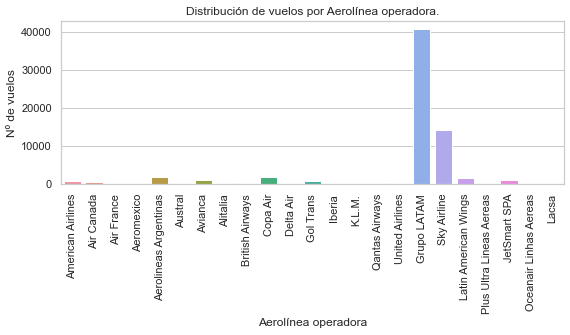

In [130]:
plt.show(plot_categories(df = df, variable_name= 'OPERA',variable_name_plot = 'Aerolínea operadora', width = 9, height = 3))

##### Revisión de las variables categóricas.
Primero que nada, revisamos la consistencia entre los datos programados y los de operación.
Naturalmente, los códigos de los orígenes nunca cambian, ya que sería muy raro o casi imposible que pasajeros tengan que cambiarlos de aeropuerto para poder tomar su vuelo.

In [76]:
df.query("`Ori-I` != `Ori-O`", engine = 'python')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Luego, con los códigos de vuelo llama la atención de que hay un grupo reducido de vuelos en el que el código de vuelo programado difiere del código de vuelo del de operación, este dato podría ser interesante, ya que se pueden ver que hay en algunos casos retrasos considerables, como en el caso de la fila 6018, que tuvo un atraso de 2 horas y media. Esta intuición la podremos verificar cuando visualizemos la diferencia entre Fecha-O y Fecha-I.

In [72]:
df.query("`Vlo-I` != `Vlo-O`", engine = 'python')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,5,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6020,2017-01-07 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-07 06:59:00,1001,SCEL,SAEZ,LAN,7,1,2017,Sabado,I,Grupo LATAM,Santiago,Buenos Aires
6022,2017-01-12 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-12 08:05:00,1003,SCEL,SAEZ,LAN,12,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6023,2017-01-13 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-13 07:06:00,1001,SCEL,SAEZ,LAN,13,1,2017,Viernes,I,Grupo LATAM,Santiago,Buenos Aires
6025,2017-01-19 10:50:00,4501,SCEL,SAEZ,LAN,2017-01-19 10:56:00,1001,SCEL,SAEZ,LAN,19,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60565,2017-11-05 22:10:00,530,SCEL,SPJC,LAN,2017-11-05 22:24:00,534,SCEL,SPJC,LAN,5,11,2017,Domingo,I,Grupo LATAM,Santiago,Lima
61354,2017-11-09 11:20:00,7811,SCEL,SAEZ,LAN,2017-11-09 12:23:00,1103,SCEL,SAEZ,LAN,9,11,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
61426,2017-11-05 16:30:00,207,SCEL,SCIE,LXP,2017-11-05 18:22:00,207R,SCEL,SCIE,LXP,5,11,2017,Domingo,N,Grupo LATAM,Santiago,Concepcion
62175,2017-12-20 19:25:00,2287,SCEL,SAEZ,ARG,2017-12-20 20:17:00,1287,SCEL,SAEZ,AUT,20,12,2017,Miercoles,I,Aerolineas Argentinas,Santiago,Buenos Aires


Observamos que el código del destino también cambia en un tamaño reducido (28) de vuelos, lo que revisaremos más adelante para revisar si significa algo o no (hay algunos que tienen retrasos hasta de 2 horas y media).

In [80]:
print(df.query("`Des-I` != `Des-O`", engine = 'python').shape)
df.query("`Des-I` != `Des-O`", engine = 'python').head()

(28, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,17,1,2017,Martes,N,Sky Airline,Santiago,Temuco
7290,2017-02-15 06:25:00,11,SCEL,SCTE,SKU,2017-02-15 06:25:00,11,SCEL,SCQP,SKU,15,2,2017,Miercoles,N,Sky Airline,Santiago,Temuco
7520,2017-02-27 06:40:00,71,SCEL,SCIE,SKU,2017-02-27 09:07:00,71,SCEL,SCQP,SKU,27,2,2017,Lunes,N,Sky Airline,Santiago,Temuco
8456,2017-02-15 06:10:00,57,SCEL,SCTE,LAN,2017-02-15 06:12:00,57,SCEL,SCQP,LAN,15,2,2017,Miercoles,N,Grupo LATAM,Santiago,Temuco
12787,2017-03-18 06:25:00,11,SCEL,SCTE,SKU,2017-03-18 06:29:00,11,SCEL,SCQP,SKU,18,3,2017,Sabado,N,Sky Airline,Santiago,Temuco


En el caso del código de la aerolínea del vuelo programado, esta diferencia entre códigos es más prominente (casi 1/3 del dataset). Este caso podría ser más común pero de igual forma aperturaremos la diferencia de los timestamps para poder evaluar si es un insight relevante o no.

In [81]:
print(df.query("`Emp-I` != `Emp-O`", engine = 'python').shape)
df.query("`Emp-I` != `Emp-O`", engine = 'python').head()

(18668, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
345,2017-01-21 22:30:00,2291,SCEL,SABE,AUT,2017-01-21 22:28:00,2291,SCEL,SABE,ARG,21,1,2017,Sabado,I,Austral,Santiago,Buenos Aires
814,2017-01-01 07:14:00,624,SCEL,SPJC,AVA,2017-01-01 07:11:00,624,SCEL,SPJC,LRC,1,1,2017,Domingo,I,Avianca,Santiago,Lima
815,2017-01-02 07:00:00,624,SCEL,SPJC,AVA,2017-01-02 07:05:00,624,SCEL,SPJC,LRC,2,1,2017,Lunes,I,Avianca,Santiago,Lima
816,2017-01-03 07:14:00,624,SCEL,SPJC,AVA,2017-01-03 07:14:00,624,SCEL,SPJC,LRC,3,1,2017,Martes,I,Avianca,Santiago,Lima
817,2017-01-04 07:00:00,624,SCEL,SPJC,AVA,2017-01-04 07:24:00,624,SCEL,SPJC,LRC,4,1,2017,Miercoles,I,Avianca,Santiago,Lima


No pareciera haber un gran desbalance en la cantidad de vuelos que operan por día de semana, aunque vale notar que el sábado es el con menor cantidad. Para sacar mayores conclusiones habrá que graficar cómo se comporta el target con esta variable.

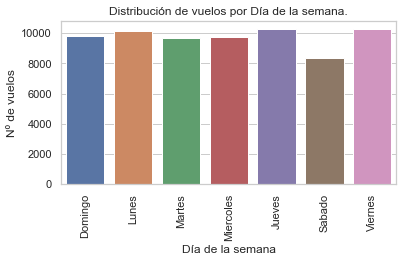

In [132]:
plt.show(plot_categories(df = df, variable_name= 'DIANOM',variable_name_plot = 'Día de la semana', width = 6, height = 3))

En cuanto a los destinos, primero revisamos cuántos de estos son nacionales y cuantos internacionales, en lo que podemos notar que están casi mitad y mitad. Dependiendo de lo que desarrollemos más adelante, uno podría proponer tener dos modelos distintos ya que ambos tipos de vuelos pueden tener naturalezas distintas.

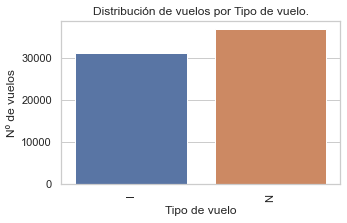

In [133]:
plt.show(plot_categories(df = df, variable_name= 'TIPOVUELO',variable_name_plot = 'Tipo de vuelo', width = 5, height = 3))

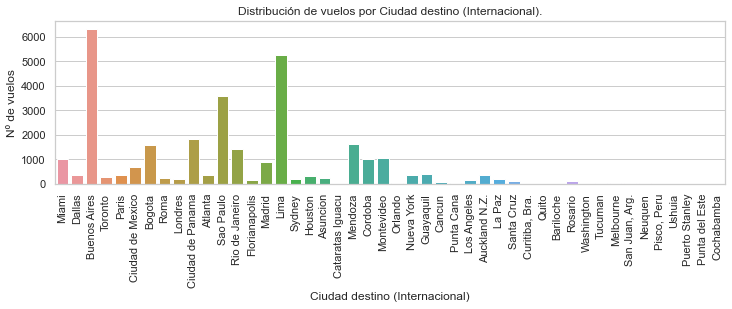

In [134]:
plt.show(plot_categories(df = df.query("TIPOVUELO == 'I'", engine = 'python'), variable_name= 'SIGLADES',variable_name_plot = 'Ciudad destino (Internacional)', width = 12, height = 3))

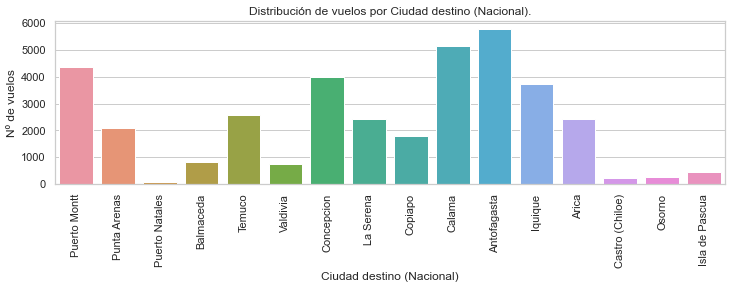

In [135]:
plt.show(plot_categories(df = df.query("TIPOVUELO == 'N'", engine = 'python'), variable_name= 'SIGLADES',variable_name_plot = 'Ciudad destino (Nacional)', width = 12, height = 3))

Observamos que el dataset está bastante balanceado para dias de mes, mes y año (y notamos que la data es casi exclusivamente del 2017). En cualquier caso, si se deseara productivizar el modelo para detectar demoras en los vuelos, se debería considerar como mínimo 1 año de datos para poder capturar la estacionalidad, al mismo tiempo que teniendo consideraciones de no mirar mucho hacia atrás (o de ser el caso, tener variables que permitan capturar una relevancia distinta o cambios (como la pandemia, por ejemplo)).

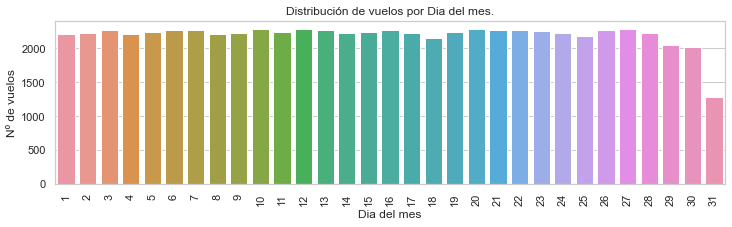

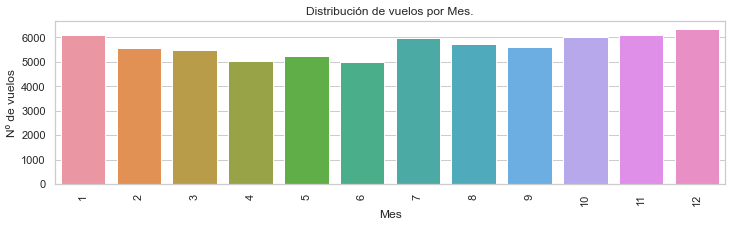

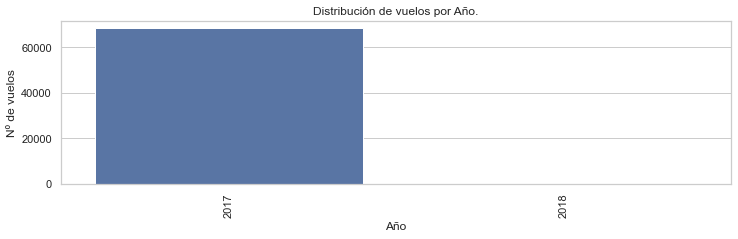

In [136]:
plt.show(plot_categories(df = df, variable_name= 'DIA',variable_name_plot = 'Dia del mes', width = 12, height = 3))
plt.show(plot_categories(df = df, variable_name= 'MES',variable_name_plot = 'Mes', width = 12, height = 3))
plt.show(plot_categories(df = df, variable_name= 'AÑO',variable_name_plot = 'Año', width = 12, height = 3))

#### Pregunta 2) Generación de columnas adicionales y visualización de target
Generamos las siguientes columnas:
* `temporada_alta`: 1 si `Fecha-I` está entre: 15 de Diciembre y 3 de Marzo | 15 de Julio y 31 de Julio | 11 de Septiembre y 30 de Septiembre y 0 si no.
* `dif_min`: diferencia en minutos entre `Fecha-I` y `Fecha-O`.
* `atraso_15`: 1 si `diff_min` > 15, 0 si no.
* `periodo_dia`: "mañana" si componente tiempo de `Fecha-I` está entre 5:00 y 11:59, "tarde", si está entre 12:00 y 18:59, o "noche" si está entre 19:00 y 4:59.

In [177]:
def temporada_alta(row):
    if ((row.MES == 12 and row.DIA >= 15) or (row.MES in [1, 2]) or (row.MES == 3 and row.DIA <= 3)):#Inicio t1: 15 del 12, Término t1: 3 del 4
        is_temporada_alta = 1
    elif row.MES == 7 and (row.DIA >= 15 and row.DIA <= 31):#Inicio t2: 15 del 7, Término t2: 31 del 7
        is_temporada_alta = 1
    elif row.MES == 9 and (row.DIA >= 11 and row.DIA <= 30):#Inicio t3: 11 del 9, Término t3: 30 del 9
        is_temporada_alta = 1
    else: 
        is_temporada_alta = 0
    return is_temporada_alta

def periodo_dia(row):
    if row['Fecha-I'].time()  >= datetime.time(5,0,0) and row['Fecha-I'].time()  < datetime.time(12,0,0):
        periodo = 'mañana'
    elif row['Fecha-I'].time()  >= datetime.time(12,0,0) and row['Fecha-I'].time()  < datetime.time(19,0,0):
        periodo = 'tarde'
    else:
        periodo = 'noche'
    return periodo

df.loc[:, 'temporada_alta'] = df.apply(temporada_alta, axis = 1)
df.loc[:, 'diff_min'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds()/60.0
df.loc[:, 'atraso_15'] = df.loc[:, 'diff_min'].apply(lambda x: 1 if x >= 15 else 0)
df.loc[:, 'periodo_dia'] = df.apply(periodo_dia, axis = 1)

Observamos que aproximadamente un 20% de los vuelos tienen atrasos de más de 15 minutos. Tendremos que tener en cuenta este desbalance al momento de formular el problema más adelante.

0    54589
1    13616
Name: atraso_15, dtype: int64
Porcentaje general de vuelos con retraso: 0.2


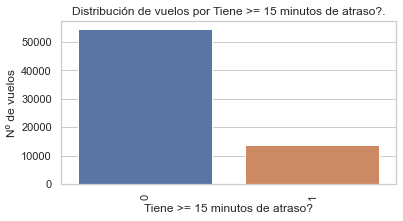

In [322]:
print(df.loc[:, 'atraso_15'].value_counts())
porcentaje_retrasos = round(df.query('atraso_15 == 1', engine='python').shape[0]/(df.shape[0]), ndigits=2)
print(f'Porcentaje general de vuelos con retraso: {porcentaje_retrasos}')
plt.show(plot_categories(df = df, variable_name= 'atraso_15', variable_name_plot= 'Tiene >= 15 minutos de atraso?'))

Observamos que la mayoría de los vuelos ocurre fuera de temporada alta, 

0    45444
1    22761
Name: temporada_alta, dtype: int64


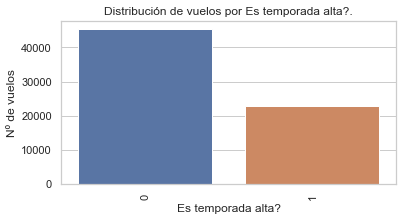

In [163]:
print(df.loc[:, 'temporada_alta'].value_counts())
plt.show(plot_categories(df, 'temporada_alta', variable_name_plot='Es temporada alta?'))

tarde     25506
mañana    25351
noche     17348
Name: periodo_dia, dtype: int64


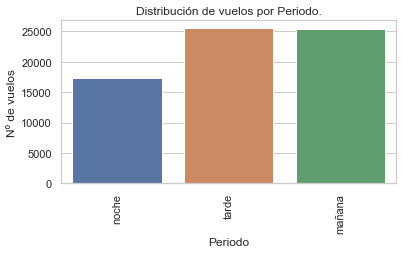

In [178]:
print(df.loc[:, 'periodo_dia'].value_counts())
plt.show(plot_categories(df, 'periodo_dia', variable_name_plot='Periodo'))

Guardamos las nuevas variables sintéticas en el archivo csv `synthetic_features.csv`:

In [179]:
df.loc[:,['temporada_alta', 'diff_min', 'atraso_15', 'periodo_dia']].to_csv('synthetic_features.csv')

#### Pregunta 3) Exploración de la distribución del target por categoría
En esta parte usaremos plotly para poder plottear tanto los porcentajes de cada clase por categoría como el tamaño en el hover.
A continuación podemos observar que la variable de "temporada alta" cuando es positiva, la tasa de vuelos con retraso aumenta un 2% en comparación con aquellos que de temporada baja. Se ve un efecto pequeño pero podría aportar para el modelo final.

In [324]:
def visualize_category(df: pd.DataFrame, category_1, category_1_name,target = 'atraso_15', target_name = "Atraso de vuelos"):
    numerator = pd.DataFrame(df.groupby([category_1, target]).size())
    denominator = pd.DataFrame(df.groupby(category_1).size())

    result = pd.DataFrame(numerator.div(denominator, level = 0, axis = 'index')*100)
    result.reset_index(inplace=True)
    result.columns = list(result.columns[:-1]) + ['percent']
    numerator.reset_index(inplace=True)
    numerator.columns = list(numerator.columns[:-1]) + ['size']
    denominator.reset_index(inplace=True)
    denominator.columns = list(denominator.columns[:-1]) + ['size']
    result = result.merge(numerator, on = [category_1, target])
    result.loc[:,'percent'] = result.loc[:,'percent'].apply(round, ndigits = 2)
    fig = px.bar(result, x=category_1, y="percent", color=target, title=f"{target_name} por {category_1_name}", text= 'size',text_auto=True, 
    barmode='relative')
    return fig
visualize_category(df = df, category_1= 'temporada_alta', category_1_name = 'categoría de temporada').show()

En cuanto a la variable de horario, el principal aprendizaje es que los vuelos de "mañana" tienen menos retrasos que el promedio general, mientras que los otros dos están por sobre la media. Denuevo, pareciera ser una variable que podrá aportar a la predictibilidad del modelo que desarrollaremos.

In [282]:
visualize_category(df = df, category_1= 'periodo_dia', category_1_name = 'periodo del día').show()

Ahora, revisando las líneas operadoras, podemos darnos cuenta que hay harta varianza entre cada una de las categorías, lo que nos ayudará a separar de mejor manera las clases positivas de las negativas.

In [291]:
fig = visualize_category(df = df, category_1= 'OPERA', category_1_name = 'aerolínea')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

El tipo de vuelo, también presenta una alta variabilidad entre categorías, por lo que definitivamente será una variable importante a considerar en el modelo final.

In [299]:
fig = visualize_category(df = df, category_1= 'TIPOVUELO', category_1_name = 'tipo de vuelo')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

Cuando aperturamos por destino, vemos que la cantidad de categorías aumenta considerablemente. Por lo anterior es que tendremos que considerar una forma de encodear estos destinos de otra manera y poder capturar de buena manera la varianza entre cada clase.

In [297]:
fig = visualize_category(df = df.query("TIPOVUELO == 'I'", engine = 'python'), category_1= 'SIGLADES', category_1_name = 'destinos internacionales')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

En cuanto a los destinos nacionales, estos parecieran ser más homogéneos entre ellos en cuanto a la tasa de retraso de vuelos, podría influir el factor que sean vuelos nacionales, o podría influir el factor distancia.

In [298]:
fig = visualize_category(df = df.query("TIPOVUELO == 'N'", engine = 'python'), category_1= 'SIGLADES', category_1_name = 'destinos nacionales')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

Sorprende que exista un día con más retrasos, que sea el día viernes. Será involucrada esta variable en el análisis para el modelo final.

In [300]:
fig = visualize_category(df = df, category_1= 'DIANOM', category_1_name = 'día de la semana')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

El mes del vuelo sorprendentemente, también tiene una varianza no menor, sorprendiendo julio del 2017. Buscando un poco en Google y haciendo memoria, ese fue el invierno que nevó en casi toda la región metropolitana, por lo que podrían haber otros factores detrás de esta varianza. Algo plausible y para no reproducir sesgo, sería incluir variables de pronóstico climático para Santiago para el día que partiría el avión. Por lo mismo, no será incluida en el análisis tal como está.

In [301]:
fig = visualize_category(df = df, category_1= 'MES', category_1_name = 'mes del año')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

En cuanto al día del mes, sorprende que haya una variabilida no menor para algunos días del mes. Cabe preguntarse entonces, si el día del mes en el 2017 influye en la distribución de los días de la semana para el 2017.

In [302]:
fig = visualize_category(df = df, category_1= 'DIA', category_1_name = 'dia del mes')
fig.update_xaxes(tickangle=90)
fig.update_layout(autosize=False, width=1280, height=700, showlegend=True)
fig.show()

Seleccionando para alguno de los días de la semana, efectivamente podemos corroborar que los días de la semana no distribuyen uniforme, por lo que la varianza que estamos observando a nivel de día del mes podría ser simplemente un efecto de la distribución igual de días de la semana por día de mes.

In [325]:
visualize_category(df = df, category_1= 'DIA', category_1_name = 'Día del mes', target='DIANOM', target_name='Día de la semana').show()

Finalmente, y a la luz de los datos preliminares, uno esperaría que las variables que mas influirían en el resultado, de mayor a menor, sería el siguiente
1. Aerolínea que tiene planificado el vuelo (`Emp-I`)
2. Si es nacional o internacional (`TIPOVUELO`)
3. Destino del vuelo (`Ori-I`)
4. El día de la semana en el que ocurre el vuelo (`DIANOM`)
5. Horario en el que ocurre el vuelo (`periodo_dia`)
6. Si es temporada alta o no (`temporada_alta`)

Como bonus, el pronóstico temporal del día que ocurre el vuelo sería muy interesante agregar a la mezcla, además de algún encoding para los destinos o si hay algún feriado en los 7 días más cercanos al despegue del vuelo. Además, ese detalle de las discrepancias entre las variables `I` y `O`, pareciera natural que son datos que se saben _ex post_ del atraso de un vuelo, por lo que no serían útiles para el modelo predictivo, aunque no por eso menos interesante.

Para obtener la información climática, obtendremos datos de la página web https://explorador.cr2.cl/, para la estación cercana al aeropuerto Arturo Merino Benítez, para las siguientes variables:
1. Temperatura media
2. Temperatura mínima
4. Temperatura máxima
3. Precipitación

Nota: para reproducibilidad, se tomaron los datos entre el 31 de diciembre del 2016 y el 30 de enero del 2018

In [338]:
t_media = pd.read_csv('t_media.csv')
t_media.columns = ['año', 'mes', 'dia', 't_media']
t_minima = pd.read_csv('t_minima.csv')
t_minima.columns = ['año', 'mes', 'dia', 't_minima']
t_maxima = pd.read_csv('t_maxima.csv')
t_maxima.columns = ['año', 'mes', 'dia', 't_maxima']
precipitacion = pd.read_csv('precipitacion.csv')
precipitacion.columns = ['año', 'mes', 'dia', 'precipitacion']
df_clima = t_media.merge(t_minima, on=['año', 'mes', 'dia']).merge(t_maxima, on=['año', 'mes', 'dia']).merge(precipitacion, on=['año', 'mes', 'dia'])

In [341]:
df = df.merge(df_clima, how='left', left_on = ['AÑO', 'MES', 'DIA'], right_on=['año', 'mes', 'dia'])
df.loc[:, 'TIPOVUELO'] = df.loc[:, 'TIPOVUELO'].apply(lambda x: 1 if x == "I" else 0)

#### Pregunta 4) Implementación de modelo(s) de machine learning

In [349]:
df_final = df.loc[:, ['Emp-I', 'TIPOVUELO', 'Des-I', 'DIANOM', 'periodo_dia', 'temporada_alta', 't_media', 't_minima', 't_maxima','atraso_15']]
df_final.sample(10)

,Emp-I,TIPOVUELO,Des-I,DIANOM,periodo_dia,temporada_alta,t_media,t_minima,t_maxima,atraso_15
20906,LAN,N,SCAR,Domingo,noche,0,15.7,7.9,25.2,0
4400,LAN,N,SCFA,Lunes,mañana,1,21.8,12.6,31.8,0
25749,LAN,N,SCFA,Martes,tarde,0,8.0,1.8,16.7,0
30221,LAN,N,SCIE,Sabado,tarde,0,10.0,7.9,13.2,0
4884,LAN,I,SABE,Sabado,tarde,1,22.7,15.0,31.8,0
28680,SKU,N,SCIE,Sabado,mañana,0,7.8,2.8,14.7,1
31510,LAN,I,KMIA,Jueves,noche,0,8.0,1.9,17.4,1
38421,AAL,I,KDFW,Sabado,noche,0,5.9,0.6,12.5,0
61853,AAL,I,KMIA,Viernes,noche,1,22.1,13.3,30.4,0
48124,LAN,N,SCCF,Viernes,noche,0,8.5,6.1,11.7,0


In [358]:

cat_features = ['Emp-I', 'Des-I', 'DIANOM', 'periodo_dia']
X = df_final.loc[:, df_final.columns != 'atraso_15']
y = df_final['atraso_15']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [369]:
model = CatBoostClassifier(auto_class_weights='Balanced')
model.fit(X_train, y_train, cat_features)
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

Learning rate set to 0.052687
0:	learn: 0.6894059	total: 65.5ms	remaining: 1m 5s
1:	learn: 0.6862598	total: 107ms	remaining: 53.2s
2:	learn: 0.6837162	total: 154ms	remaining: 51s
3:	learn: 0.6814780	total: 199ms	remaining: 49.6s
4:	learn: 0.6791397	total: 258ms	remaining: 51.4s
5:	learn: 0.6769685	total: 304ms	remaining: 50.4s
6:	learn: 0.6758078	total: 333ms	remaining: 47.2s
7:	learn: 0.6738154	total: 401ms	remaining: 49.7s
8:	learn: 0.6717827	total: 444ms	remaining: 48.9s
9:	learn: 0.6701113	total: 532ms	remaining: 52.7s
10:	learn: 0.6684080	total: 578ms	remaining: 51.9s
11:	learn: 0.6668376	total: 622ms	remaining: 51.2s
12:	learn: 0.6650912	total: 680ms	remaining: 51.6s
13:	learn: 0.6633717	total: 733ms	remaining: 51.6s
14:	learn: 0.6616586	total: 793ms	remaining: 52.1s
15:	learn: 0.6603746	total: 849ms	remaining: 52.2s
16:	learn: 0.6592081	total: 893ms	remaining: 51.6s
17:	learn: 0.6581555	total: 943ms	remaining: 51.5s
18:	learn: 0.6572310	total: 985ms	remaining: 50.9s
19:	learn: 0

#### Pregunta 4) Evaluación de los modelos de machine learning
Para la evaluación del modelo cabe preguntarnos, qué es más crítico para el negocio? Los falsos positivos (aviones que se detectan como atrasados pero no lo son) o los falsos negativos (aviones que no fueron detectados como atrasados pero sí se atrasaron)?
Nos tomaremos del segundo caso, argumentando que no tomar acciones proactivas con vuelos que se puedan atrasar puede degradar de manera significativa la experiencia del cliente, dado que en muchos casos éstos tienen agendas apretadas (reservaciones, otros vuelos en conexión, compromisos, etc).

Por lo mismo, es que evaluaremos inicialmente el modelo con `Recall`, que representa cuántos de los vuelos atrasados estamos siendo capaces de poder detectar.

<AxesSubplot:>

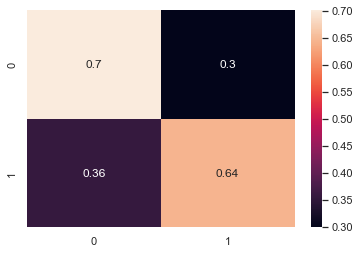

In [370]:
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = preds_class, normalize='true'), annot=True)

In [371]:
model.get_feature_importance()

array([15.49011105,  4.1302511 , 14.4681826 ,  8.83744152, 10.10383505,
        2.10494147, 13.42684503, 17.71111771, 13.72727447])

Text(0.5, 1.0, 'Feature Importance')

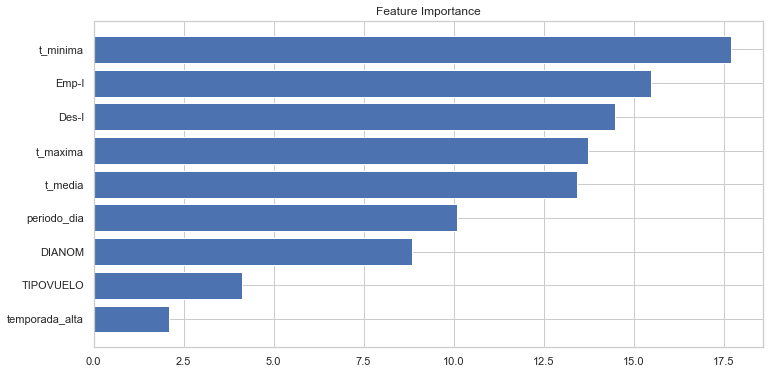

In [372]:
feature_importance = model.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


#### Pregunta 4) Iteraciones (nuevas variables)
Tal como mencioné antes, una variable que parecía interesante, era la distancia entre los dos aeropuertos. Después de buscar un poco descubrí que el código estaba en una convención llamada **ICAO**, por lo que nos servirá para poder usarla como llave para obtener más detalles de los datos que tenemos.

Encontré la librería **airportsdata** que pareciera estar bastante actualizada y completa, y la usaremos para obtener las tuplas de latitudes y longitudes.

In [382]:
airports = airportsdata.load('ICAO')  # key is the LID identifier (the default)

Hacemos una nueva selección pero tomando en cuenta la columna `Ori-C`:

In [434]:
df_final2 = df.loc[:, ['Ori-I','Emp-I', 'TIPOVUELO', 'Des-I', 'DIANOM', 'periodo_dia', 'temporada_alta', 't_media', 't_minima', 't_maxima','atraso_15']]

Usando el diccionario `airports` me dí cuenta que había un par de casos borde que no estaban contemplados en la librería, por lo que los agregué e introduje manualmente segun información en Wikipedia:

In [435]:
print(set(df_final['Des-I'].unique()) - set(list(airports.keys())))
def manage_border_cases(x):
    if x == 'SCQP': #Aeropuerto Old Mariscal Sucre International Airport https://geohack.toolforge.org/geohack.php?pagename=Old_Mariscal_Sucre_International_Airport&params=00_08_28_S_078_29_17_W_region:EC_type:airport
        return  (-0.1411111, -78.488056)
    elif x == 'SEQU':#Aeropuerto Internacional Araucanía https://geohack.toolforge.org/geohack.php?language=es&pagename=Aeropuerto_Internacional_La_Araucan%C3%ADa&params=-38.9258_N_-72.6514_E_type:airport
        return (-38.9258, -72.6514)
    else:
        return (airports[x]['lat'], airports[x]['lon']) 

{'SEQU', 'SCQP'}


Aplicamos la versión corregida sobre los destinos para obtener las tuplas:

In [436]:
df_final2.loc[:,'coord-Ori-I'] = df_final2.loc[:,'Ori-I'].apply(lambda x: (airports[x]['lat'], airports[x]['lon']))
df_final2.loc[:,'coord-Des-I'] = df_final2.loc[:,'Des-I'].apply(lambda x: manage_border_cases(x))

Importamos la librería `geopy` para calcular la distancia esférica más cercana entre dos latitudes (crédito a https://towardsdatascience.com/finding-distance-between-two-latitudes-and-longitudes-in-python-43e92d6829ff que me iluminó sobre la librería):

Aplicamos la función para obtener la nueva variable `distance_km`:

In [438]:
df_final2.loc[:, 'distance_km'] = df_final2.apply(lambda x: GD(x['coord-Ori-I'], x['coord-Des-I']).km, axis = 1)

In [439]:
df_final2.head()

,Ori-I,Emp-I,TIPOVUELO,Des-I,DIANOM,periodo_dia,temporada_alta,t_media,t_minima,t_maxima,atraso_15,coord-Ori-I,coord-Des-I,distance_km
0,SCEL,AAL,1,KMIA,Domingo,noche,1,22.3,13.4,32.3,0,"(-33.3930015564, -70.7857971191)","(25.7953611111111, -80.2901158333333)",6627.342331
1,SCEL,AAL,1,KMIA,Lunes,noche,1,23.5,15.3,32.6,0,"(-33.3930015564, -70.7857971191)","(25.7953611111111, -80.2901158333333)",6627.342331
2,SCEL,AAL,1,KMIA,Martes,noche,1,20.9,12.7,30.5,0,"(-33.3930015564, -70.7857971191)","(25.7953611111111, -80.2901158333333)",6627.342331
3,SCEL,AAL,1,KMIA,Miercoles,noche,1,21.4,12.1,30.8,0,"(-33.3930015564, -70.7857971191)","(25.7953611111111, -80.2901158333333)",6627.342331
4,SCEL,AAL,1,KMIA,Jueves,noche,1,22.8,13.2,33.3,0,"(-33.3930015564, -70.7857971191)","(25.7953611111111, -80.2901158333333)",6627.342331


Droppeamos las columnas `Ori-I`, `coord-Ori-I` y `coord-Des-I`, ya que no nos serán de utilidad para entrenar nuevamente el modelo:

In [440]:
df_final2.drop(['Ori-I', 'coord-Ori-I', 'coord-Des-I'],axis = 1, inplace=True)

In [441]:
df_final2

,Emp-I,TIPOVUELO,Des-I,DIANOM,periodo_dia,temporada_alta,t_media,t_minima,t_maxima,atraso_15,distance_km
0,AAL,1,KMIA,Domingo,noche,1,22.3,13.4,32.3,0,6627.342331
1,AAL,1,KMIA,Lunes,noche,1,23.5,15.3,32.6,0,6627.342331
2,AAL,1,KMIA,Martes,noche,1,20.9,12.7,30.5,0,6627.342331
3,AAL,1,KMIA,Miercoles,noche,1,21.4,12.1,30.8,0,6627.342331
4,AAL,1,KMIA,Jueves,noche,1,22.8,13.2,33.3,0,6627.342331
...,...,...,...,...,...,...,...,...,...,...,...
68200,JAT,1,SPJC,Viernes,tarde,1,22.1,13.3,30.4,1,2452.971422
68201,JAT,1,SPJC,Lunes,tarde,1,22.8,13.4,32.5,1,2452.971422
68202,JAT,1,SPJC,Miercoles,tarde,1,23.1,14.6,31.7,1,2452.971422
68203,JAT,1,SPJC,Viernes,tarde,1,23.7,13.6,33.0,0,2452.971422


In [442]:
cat_features = ['Emp-I', 'Des-I', 'DIANOM', 'periodo_dia']
X = df_final2.loc[:, df_final2.columns != 'atraso_15']
y = df_final2['atraso_15']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [444]:
model2 = CatBoostClassifier(auto_class_weights='Balanced')
model2.fit(X_train, y_train, cat_features)
preds_class2 = model2.predict(X_test)
preds_proba2 = model2.predict_proba(X_test)

c:\Users\marti\anaconda3\lib\site-packages\catboost\core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Learning rate set to 0.052687
0:	learn: 0.6901422	total: 42ms	remaining: 42s
1:	learn: 0.6870612	total: 95.8ms	remaining: 47.8s
2:	learn: 0.6843644	total: 142ms	remaining: 47.2s
3:	learn: 0.6817297	total: 184ms	remaining: 45.8s
4:	learn: 0.6795880	total: 240ms	remaining: 47.8s
5:	learn: 0.6775273	total: 289ms	remaining: 47.9s
6:	learn: 0.6751581	total: 346ms	remaining: 49.1s
7:	learn: 0.6730985	total: 389ms	remaining: 48.2s
8:	learn: 0.6711895	total: 439ms	remaining: 48.3s
9:	learn: 0.6697487	total: 480ms	remaining: 47.5s
10:	learn: 0.6678005	total: 565ms	remaining: 50.8s
11:	learn: 0.6663924	total: 626ms	remaining: 51.5s
12:	learn: 0.6652167	total: 671ms	remaining: 50.9s
13:	learn: 0.6640206	total: 712ms	remaining: 50.1s
14:	learn: 0.6627733	total: 755ms	remaining: 49.6s
15:	learn: 0.6617414	total: 811ms	remaining: 49.9s
16:	learn: 0.6608251	total: 862ms	remaining: 49.9s
17:	learn: 0.6596249	total: 919ms	remaining: 50.1s
18:	learn: 0.6584702	total: 965ms	remaining: 49.8s
19:	learn: 0.

<AxesSubplot:>

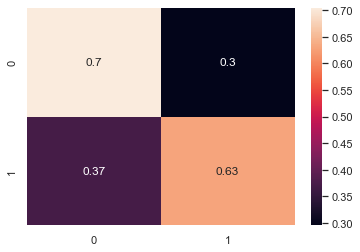

In [445]:
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = preds_class2, normalize='true'), annot=True)

Text(0.5, 1.0, 'Feature Importance')

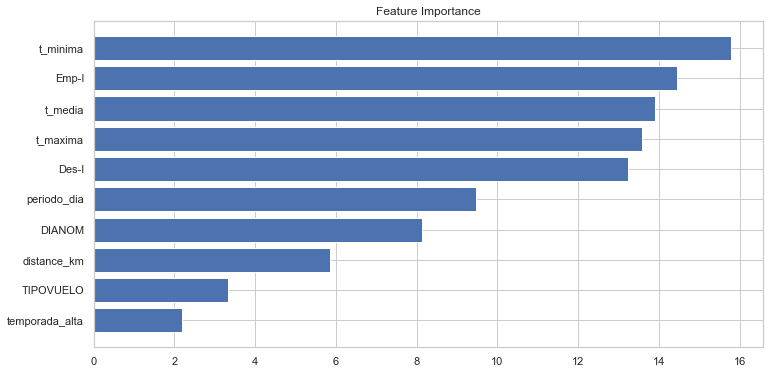

In [446]:
feature_importance = model2.get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [447]:
#### Optimización de hiperparámetros
parameters = {'depth': [4,5,6,7,8,9, 10],
'learning_rate' : [0.01,0.02,0.03,0.04],
'iterations'    : [10, 20,30,40,50,60,70,80,90, 10]
}

In [451]:
model3 = CatBoostClassifier(auto_class_weights='Balanced')
Grid_Catboost = GridSearchCV(estimator = model3, param_grid=parameters, cv= 10, n_jobs=-1, scoring='recall')
Grid_Catboost.fit(X_train, y_train, cat_features = cat_features)

KeyboardInterrupt: 

#### Pregunta 4) Conclusión

Evaluando el modelo y agregando las mejoras que se hicieron agregando las nuevas variables, hay varios posibles pasos a seguir:
1) Re-evaluar el set de variables inicial, ver si es necesario recortar variables, encoddear existentes de otra manera, etc.
2) Explorar otros modelos y hacer un benchmark
3) Buscar más combinaciones de hiperparámetros que puedan dar un resultado más óptimo
4) Indagar en detalle los casos que está prediciendo mal el modelo y entender por qué y ver si esos datos darían nuevas luces de otras variables.

De ambos intentos, logré un 64% de recall. Utilicé esta métrica en particular por las razones que expuse más arriba, pero principalmente por la gravedad del problema que representa no tomar acciones proactivas con retrasos de vuelos, que además entiendo por lo menos a nivel Chileno está muy regulado el tema de los atrasos de los aviones. Por lo tanto, la necesidad de bajar los falsos negativos es la que prima.

Dentro de las variables que más influyeron en la predicción, fueron:
1) La temperatura mínima -> debe estar muy correlacionada a la subida notoria de retrasos que hubo con la nevada de Julio
2) La aerolínea que las opera -> sin tener mayor contexto de como caracterizar cada aerolínea, pareciera ser importante quien la opera, cuanto se atrasa.
3) El destino -> pareciera haber destinos más complicados que otros. Sorprendió que la variable distancia no tuviera una preponderancia tan grande.